**Learning distribution with Neural Spline Flow**

In [1]:
%pylab inline 

import jax
import jax.numpy as jnp
from jax.experimental import optix
import haiku as hk
import tensorflow_probability as tfpp; tfp = tfpp.experimental.substrates.jax
from functools import partial
from nf.real_nvp import RealNVP

tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [2]:
print("TFP Version", tfpp.__version__)
print("JAX  Version",jax.__version__)
print("Haiku  Version",hk.__version__)

TFP Version 0.11.0
JAX  Version 0.1.73
Haiku  Version 0.0.2


In [3]:
class NeuralSplineCoupling(hk.Module):
    def __init__(self, nunits, name, nbins=32):
        super(NeuralSplineCoupling, self).__init__(name=name)
        self.nunits = nunits
        self.nbins = nbins
        
    def bin_positions(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins])
        return jax.nn.softmax(x, axis=-1) *  (2. - self.nbins * 1e-2) + 1e-2
  
    def slopes(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins - 1])
        return jax.nn.softplus(x) + 1e-2
    
    def __call__(self, x, nunits):
        net = jax.nn.leaky_relu(hk.Linear(128)(x))
        net = jax.nn.leaky_relu(hk.Linear(128)(net))

        bin_widths = self.bin_positions(hk.Linear(nunits*self.nbins)(net))
        bin_heights = self.bin_positions(hk.Linear(nunits*self.nbins)(net))
        knot_slopes = self.slopes(hk.Linear(nunits*(self.nbins-1))(net))

        return tfb.RationalQuadraticSpline(
                bin_widths=bin_widths,
                bin_heights=bin_heights,
                knot_slopes=knot_slopes)

In [4]:
class NeuralSplineFlow(hk.Module):
    def __init__(self):
        super(NeuralSplineFlow, self).__init__()
    
    def __call__(self, x):
        spline1 = NeuralSplineCoupling(1, 'coupling1')
        spline2 = NeuralSplineCoupling(1, 'coupling2')
        spline3 = NeuralSplineCoupling(1, 'coupling3')

        # Computes the likelihood of these x
        chain = tfb.Chain([
            tfb.Scale(10),
            RealNVP(1, bijector_fn=spline1),
            tfb.Permute([1,0]),
            RealNVP(1, bijector_fn=spline2),
            tfb.Permute([1,0]),
            RealNVP(1, bijector_fn=spline3),
            tfb.Permute([1,0]),
            tfb.Scale(0.1)
        ])

        nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(2,))

        return nvp.log_prob(x)

In [5]:
def forward2(x):
    flow = NeuralSplineFlow()
    return flow(x)
             
model = hk.transform(forward2, apply_rng=True)

In [6]:
optimizer = optix.adam(1e-3)

In [7]:
# Now let's draw ou famous two moons
from sklearn import datasets

# Experimenting with only a fixed number of points
batch_size=512
def get_batch():
    x, y = datasets.make_moons(n_samples=batch_size, noise=.05)
    return {'x': x}

In [8]:
@jax.jit
def loss_fn(params, rng_key, batch):
    log_prob = model.apply(params, rng_key, batch['x'])
    return -jnp.mean(log_prob)

In [9]:
@jax.jit
def update(params, rng_key, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [10]:
rng_seq = hk.PRNGSequence(42)
params = model.init(next(rng_seq), jnp.zeros((1, 2)))
opt_state = optimizer.init(params)


/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or t

In [11]:
losses = []
for step in range(2000):
    batch = get_batch()
    loss, params, opt_state = update(params, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(loss)

2.630994
0.7480911
0.5105627
0.39065757
0.41135883
0.4119398
0.47298628
0.35660088
0.2970844
0.3706001
0.33797002
0.3223779
0.32347554
0.37158418
0.48574823
0.4133128
0.33244422
0.3541345
0.42398256
0.36779997


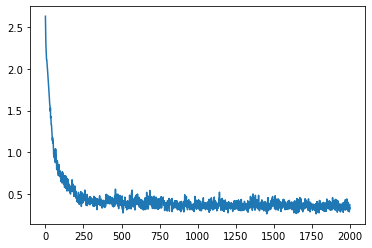

In [12]:
plot(losses)

In [13]:
xc,yc = meshgrid(linspace(-1.5,2.5,204),linspace(-1.,1.5,128))
Z = stack([xc.flatten(), yc.flatten()],axis=1).astype('float32')
print(Z.shape, Z.dtype)

(26112, 2) float32


In [14]:
S = model.apply(params, next(rng_seq), Z)

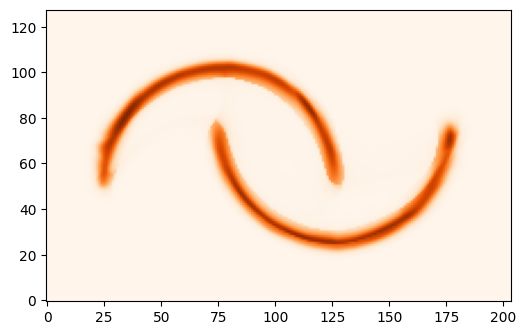

In [15]:
figure(dpi=100)
imshow(exp(S.reshape((128,204))), cmap='Oranges', origin='lower')
#axis('off')

In [16]:
# Let's compute the score function (gradient of the log likelihood)
log_prob = partial(model.apply, params, next(rng_seq))
log_prob(jnp.zeros(2).reshape(1,2)).shape

def log_prob_reshaped(x):
    return jnp.reshape(log_prob(x), ())

score = jax.vmap(jax.grad(log_prob_reshaped))

In [17]:
v_batched = jnp.zeros(10).reshape(5,1,2)
score(v_batched)

DeviceArray([[[35.96991 , 20.056293]],

             [[35.96991 , 20.056293]],

             [[35.96991 , 20.056293]],

             [[35.96991 , 20.056293]],

             [[35.96991 , 20.056293]]], dtype=float32)

In [18]:
n = 28

#figure(dpi=100)
X = linspace(-1.5,2.5,n)
Y = linspace(-1.,1.5,n)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 1, 2))
g = score(points).reshape((n, n, 2))
#print(g.shape)
#g = score(points).reshape([len(Y), len(X), 2])
_x = linspace(0, 204, n)
_y = linspace(0, 128, n)

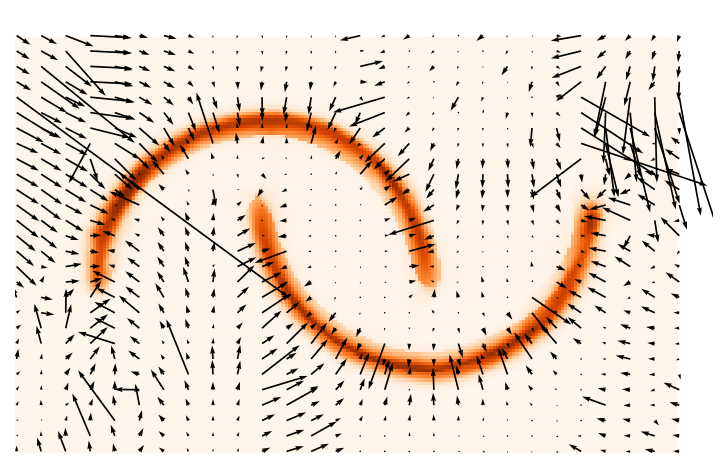

In [19]:
figure(dpi=150)
imshow(exp(S.reshape((128,204))), cmap='Oranges', origin='lower')
axis('off')
quiver(_x, _y, g[:,:,0], g[:,:,1])